In [22]:
%%bash
export DATASETS_VERBOSITY=error
export TOKENIZERS_VERBOSITY=error
export TRANSFORMERS_VERBOSITY=error

In [23]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    default_data_collator,
)

In [24]:
import lang2vec as l2v

In [25]:
from pathlib import Path
import functools as ft
import torch

In [26]:
import evaluate
import pandas as pd
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

In [27]:
import pandas as pd
import re

In [28]:
from rich.pretty import pprint

In [29]:
import logging

Misc functions:

In [30]:
def cuda_report():
    avail = torch.cuda.is_available()
    ngpu = torch.cuda.device_count()
    print(f"GPUs available? {avail}")
    print(f"Number of GPUs: {ngpu}")

In [31]:
def invert_dict(d):
    return {v: k for k,v in d.items()}

Human readable languages

In [32]:
LANGUAGES_PATH = "../data/ntrex/LANGUAGES_tab.tsv"

In [33]:
lang_to_human_readable_language = pd.read_csv(
    LANGUAGES_PATH, sep="\t", 
    header=None, names=["language_code", "language"]
).set_index('language_code').language.to_dict()

temporary = {}
for lang, long_lang in lang_to_human_readable_language.items():
    lang_no_orth = lang.split("-")[0]
    long_lang_no_orth = re.sub(pattern="\(.*\)", repl="", string=long_lang).strip()
    if lang_no_orth not in lang_to_human_readable_language:
        temporary[lang_no_orth] = long_lang_no_orth
        
lang_to_human_readable_language.update(temporary)

In [34]:
def human_readify_lang_code(lang_code: str):
    language = lang_to_human_readable_language.get(lang_code, "UNKNOWN")
    return f"{language} ({lang_code})"

### Loading the data without preprocessing a la `click_finetune_xlmr.py`

In [35]:
FLORES_PATH = "../data-bin/flores-dev-no-orth/"
NTREX_PATH = "../data-bin/ntrex-no-orth/"
FLORES_WITH_ORTH_PATH = "../data/flores200/dev/"

MODEL_NAME = "xlm-roberta-base"
LABEL_COLUMN = "language"
TEXT_COLUMN = "text"

MAX_LENGTH_TOKENS=128

In [36]:
import datasets as ds

We can first break the data loading from `click_finetune_xlmr.py` to separate small functions:

First, we need something for loading the raw FLORES/NTREX data from disk:

In [37]:
def load_flores_ntrex(
    flores_path,
    ntrex_path
):
    flores = ds.load_from_disk(flores_path)
    ntrex = ds.load_from_disk(ntrex_path)

    # Create language -> integer id mapping
    all_langs_in_common = {lang for lang in flores} & {lang for lang in ntrex}
    language_to_id = {language: i for i, language in enumerate(all_langs_in_common)}
    id_to_language = {i: language for language, i in language_to_id.items()}
    
    return flores, ntrex, language_to_id, id_to_language

In [38]:
flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(FLORES_PATH, NTREX_PATH)

In [39]:
FINETUNE_LANGS = ["fin", "eng"]
TEST_LANGS = ["fin", "eng"]

Second, we'll want functionality to only keep a subset of languages in each dataset: 

In [40]:
def stack_finetune_and_test_data(ntrex, flores, finetune_langs, test_langs):
    
    if not finetune_langs:
        finetune_langs = [lang for lang in ntrex]
    elif finetune_langs == "flores":
        finetune_langs = [lang for lang in flores if lang in ntrex]
    
    if not test_langs:
        test_langs = [lang for lang in flores]
    
    # Define new dataset based on label column and finetuning langs
    data_for_finetune = ds.concatenate_datasets(
        [ntrex[lang] for lang in finetune_langs]
    )
    
    data_for_test = ds.concatenate_datasets([flores[lang] for lang in test_langs])
    
    return data_for_finetune, data_for_test

We also want to encapsulate renaming columns:

In [41]:
def rename_columns(dataset, col_from_to):
    for col_from, col_to in col_from_to:
        if col_to not in dataset.column_names:
            dataset = dataset.rename_column(col_from, col_to)
    return dataset

In [42]:
def _rename_text_and_label_col(dataset, text_column, label_column):
    rename_these = [(text_column, "text"), (label_column, "label")]
    return rename_columns(dataset, rename_these)

rename_text_and_label_col = ft.partial(_rename_text_and_label_col,
                                       text_column=TEXT_COLUMN, 
                                       label_column=LABEL_COLUMN)

With these changes, we have the following function for text classification.

Note that a lot of the "heavy lifting" happens using `intermediate_functions`.

In [43]:
def load_data_for_text_clf(
    flores_path,
    ntrex_path,
    model_name,
    label_column,
    text_column,
    finetune_langs,
    test_langs,
    max_length_tokens,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )
    
    # STEP 2: STACK INTO data_for_finetune, data_for_test
    data_for_finetune, data_for_test = stack_finetune_and_test_data(
        ntrex, flores, finetune_langs, test_langs
    )
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

In [44]:
_load_data_for_text_clf = ft.partial(load_data_for_text_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MODEL_NAME,
    label_column=LABEL_COLUMN,
    text_column=TEXT_COLUMN,
    finetune_langs=FINETUNE_LANGS,
    test_langs=TEST_LANGS,
    max_length_tokens=MAX_LENGTH_TOKENS)

## Loading data for various tasks

### Language ID

In [45]:
data_for_finetune, data_for_test, flores, ntrex, language_to_id, id_to_language = \
_load_data_for_text_clf(
    intermediate_functions=[rename_text_and_label_col]
)

Executing intermediate func: _rename_text_and_label_col


In [46]:
data_for_finetune

Dataset({
    features: ['text', 'label'],
    num_rows: 3994
})

In [47]:
data_for_finetune[123]

{'text': 'Luonnononnettomuudet tekevät logistiikasta vielä monimutkaisempaa.',
 'label': 'fin'}

### Orthography ID

In [48]:
from collections import defaultdict

In [49]:
def get_lang_and_orthography(path: Path) -> str:
    return path.name.replace(".dev", "").split("_")

def get_flores_lang2orth(flores_dev_path: str = "../data/flores200/dev/") -> dict[str, str]:
    files = list(Path(flores_dev_path).glob("*.dev"))
    out = defaultdict(list)
    for p in files:
        lang, orth = get_lang_and_orthography(p)
        out[lang].append(orth)
    return out

def add_new_column(dataset: ds.Dataset, column_name: str, column_values: list):
    return dataset.add_column(column_name, column_values)

def _add_orthography_column(dataset, lang2orth_map, language_column="language"):
    orths = [lang2orth_map[lang][0] if lang in lang2orth_map else "unknown" for lang in dataset[language_column]]
    return add_new_column(dataset, column_name="orthography", column_values=orths)

In [50]:
flores_lang2orth = get_flores_lang2orth(FLORES_WITH_ORTH_PATH)

add_orthography_column = ft.partial(
    _add_orthography_column, 
    lang2orth_map=flores_lang2orth, 
    language_column="language"
)

rename_orth_to_label = ft.partial(_rename_text_and_label_col,
                                  text_column=TEXT_COLUMN, 
                                  label_column="orthography")

In [51]:
data_for_finetune, data_for_test, flores, ntrex, language_to_id, id_to_language = \
_load_data_for_text_clf(
    intermediate_functions=[add_orthography_column, rename_orth_to_label]
)

Executing intermediate func: _add_orthography_column
Executing intermediate func: _rename_text_and_label_col


In [52]:
data_for_finetune[123]

{'text': 'Luonnononnettomuudet tekevät logistiikasta vielä monimutkaisempaa.',
 'language': 'fin',
 'label': 'Latn'}

## Is this sentence pair related?

In [53]:
flores['fin'][0]

{'text': 'Stanfordin yliopiston lääketieteen laitoksen tutkijat ilmoittivat maanantaina uuden diagnostiikkatyökalun keksimisestä: solut tyypin mukaan lajitteleva pienenpieni tulostettava siru, joka voidaan valmistaa normaaleilla mustesuihkutulostimilla mahdollisesti noin yhden Yhdysvaltain sentin kappalehintaan.',
 'language': 'fin'}

In [54]:
flores['eng'][[0, 4]]

{'text': ['On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.',
  'Local media reports an airport fire vehicle rolled over while responding.'],
 'language': ['eng', 'eng']}

1. pick language pair
2. pick `n_pos` indices to represent positive pairs
3. pick `n_neg` indices to represent negative pairs

In [55]:
import numpy as np

In [56]:
SEED = 12345

In [57]:
np.random.seed(12345)

In [58]:
import random

In [59]:
import itertools as it

In [60]:
from rich.progress import track

In [61]:
def create_pairs_data(dataset, lang_pairs, n_pos, n_neg, num_rows):

    indices = [ix for ix in range(num_rows)]
    if n_pos > 0:
        positive_indices = np.random.randint(low=0, high=num_rows, size=n_pos)
    else:
        positive_indices = indices
    
    potential_negative_pairs = [
        (a, b) for a, b in it.combinations(indices, 2) if a != b
    ]
    
    if n_neg > 0:
        negative_indices = np.random.choice(
            range(len(potential_negative_pairs)), size=n_neg
        )
    else:
        negative_indices = range(len(potential_negative_pairs))
        
    negative_indices = [potential_negative_pairs[idx] for idx in negative_indices]
    
    for pair in track(lang_pairs, description="Creating language pair data...."):
        lang1, lang2 = pair.split("-")

        positive_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": dataset[lang1][int(ix)]["text"],
                "sentence2": dataset[lang2][int(ix)]["text"],
                "label": "yes",
            }

            for ix in positive_indices
        ]

        
        negatives = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": dataset[lang1][a]["text"],
                "sentence2": dataset[lang2][b]["text"],
                "label": "no",
            }

            for a, b in negative_indices
        ]

        sentence_pairs = ds.Dataset.from_pandas(
            pd.DataFrame.from_records(positive_examples + negatives)
        )

        return sentence_pairs

In [62]:
def load_data_for_sentence_pair_clf(
    flores_path,
    ntrex_path,
    lang_pairs,
    n_pos, n_neg,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )

    # STEP 2: CREATE PAIRS
    data_for_finetune = create_pairs_data(ntrex, lang_pairs, n_pos, n_neg, num_rows=ntrex["eng"].num_rows)
    data_for_test = create_pairs_data(flores, lang_pairs, n_pos, n_neg, num_rows=flores["eng"].num_rows)
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

_load_data_for_sentence_pair_clf = ft.partial(
    load_data_for_sentence_pair_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
)

In [63]:
rows_in_flores = flores['eng'].num_rows
rows_in_ntrex = ntrex['eng'].num_rows
lang_pairs = ["eng-fin"]
n_pos = 800
n_neg = 800

In [64]:
import pandas as pd

In [65]:
(
    sp_data_for_finetune,
    sp_data_for_test,
    flores,
    ntrex,
    language_to_id,
    id_to_language,
) = _load_data_for_sentence_pair_clf(lang_pairs=['eng-fin'], n_pos=n_pos, n_neg=n_neg)

Output()

Output()

In [66]:
sp_data_for_finetune

Dataset({
    features: ['language1', 'language2', 'sentence1', 'sentence2', 'label'],
    num_rows: 1600
})

In [67]:
sp_data_for_test

Dataset({
    features: ['language1', 'language2', 'sentence1', 'sentence2', 'label'],
    num_rows: 1600
})

In [68]:
data_for_finetune[1]

{'text': 'Jotkin edustajiston jäsenet ovat hämmentyneet ehdotuksesta, jonka mukaan heidän arvonimekseen tulisi vaihtaa MWP, eli Walesin parlamentin jäsen (Member of the Welsh Parliament).',
 'language': 'fin',
 'label': 'Latn'}

## Preprocessing functions for different tasks

In `transformers` we need to call `preprocess_fn` once per batch. An example of such a function is this function from `click_finetune_xlmr.py`:

```python
def preprocess_function(examples):
    inputs = examples["text"]
    labels = [language_to_id[label] for label in examples["label"]]

    model_inputs = tokenizer(
        inputs, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs["label"] = labels

    return model_inputs
```

In words, this does the following:

1. Grabs the right column as inputs
2. Converts labels (in this case, `language`) to numeric IDs
3. Performs tokenization -> saves result as dict
4. Adds labels to the same dict

Let's abstract this a bit

### Single sentence classification

Let's see how it works for the `xlm-r` tokenizer:

In [69]:
from transformers import AutoTokenizer

In [70]:
xlmr_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [71]:
def single_sentence_preprocess_function(examples, label_to_id, tokenizer, max_length_tokens=128):
    inputs = examples["text"]
    labels = [label_to_id[label] for label in examples["label"]]

    model_inputs = tokenizer(
        inputs, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs['tokens'] = [
        tokenizer.convert_ids_to_tokens(ids) 
        for ids in model_inputs['input_ids']
    ]
    model_inputs["label"] = labels

    return model_inputs


In [72]:
EXAMPLE_INPUTS = {"text": ["i want ice cream", "you want bread but have none"], "label": ["positive", "negative"]}
LABEL2ID = {"positive": 1, "negative": 0}

EXAMPLE_OUTPUTS = single_sentence_preprocess_function(EXAMPLE_INPUTS, LABEL2ID, xlmr_tokenizer)

In [73]:
EXAMPLE_OUTPUTS

{'input_ids': [[0, 17, 3444, 6, 2980, 24709, 2, 1, 1], [0, 398, 3444, 179967, 1284, 765, 351, 13, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]], 'tokens': [['<s>', '▁i', '▁want', '▁', 'ice', '▁cream', '</s>', '<pad>', '<pad>'], ['<s>', '▁you', '▁want', '▁bread', '▁but', '▁have', '▁non', 'e', '</s>']], 'label': [1, 0]}

### Sentence pair classification

In [74]:
def sentence_pair_preprocess_function(examples, label_to_id, tokenizer, max_length_tokens=128, 
                                      sentence1_col="sentence1", sentence2_col="sentence2",
                                      label_col="label"):
    
    first_sents = examples[sentence1_col]
    second_sents = examples[sentence2_col]
    
    labels = [label_to_id[label] for label in examples[label_col]]

    model_inputs = tokenizer(
        first_sents, second_sents, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs['tokens'] = [
        tokenizer.convert_ids_to_tokens(ids) 
        for ids in model_inputs['input_ids']
    ]
    model_inputs["label"] = labels

    return model_inputs


In [75]:
LAB2ID_SENTPAIR = {'yes': 0, 'no': 1}

In [76]:
_sentence_pair_preprocess = ft.partial(
    sentence_pair_preprocess_function,
    label_to_id=LAB2ID_SENTPAIR,
    tokenizer=xlmr_tokenizer,
    max_length_tokens=MAX_LENGTH_TOKENS
)

## Distances

Phonological distance

In [77]:
import lang2vec.lang2vec as l2v
import seaborn as sns

In [78]:
l2v.DISTANCES

['genetic', 'geographic', 'syntactic', 'inventory', 'phonological', 'featural']

In [79]:
def get_distance_matrix(distance_type, make_human_readable=False):
    _langs = [
        f"{lang_to_human_readable_language[l]} ({l})" 
        if make_human_readable else l 
        for l in language_to_id
    ]
    distance_matrix = l2v.distance(distance_type, [lang for lang in language_to_id])
    distance_matrix = pd.DataFrame(distance_matrix, index=_langs, columns=_langs)
    return distance_matrix

In [80]:
distance_matrices = {
    distance_type: get_distance_matrix(distance_type)
    for distance_type in l2v.DISTANCES
}

In [81]:
distance_matrices_human_readable = {
    distance_type: get_distance_matrix(distance_type, make_human_readable=True)
    for distance_type in l2v.DISTANCES
}

#### Plot the heatmaps

In [82]:
import matplotlib.pyplot as plt

In [83]:
def plot_heatmaps_all_distances(make_human_readable=False):
    n_col = 3
    n_row = 2
    row_col_indices = sorted(it.product(range(n_row), range(n_col)))

    heatmap_fig, heatmap_axes = plt.subplots(ncols=n_col, nrows=n_row, figsize=(48, 24))
    _distance_matrices = {True: distance_matrices_human_readable, False: distance_matrices}[make_human_readable]
    for (distance_type, matrix), (row_ix, col_ix) in zip(_distance_matrices.items(), row_col_indices):
        axis = heatmap_axes[row_ix][col_ix]
        sns.heatmap(matrix, ax=axis)
        avg = np.round(np.array(matrix).mean(axis=None), 2)
        axis.set_title(f"Distance: {distance_type} (avg: {avg})")
        
    if make_human_readable:
        plt.tight_layout()

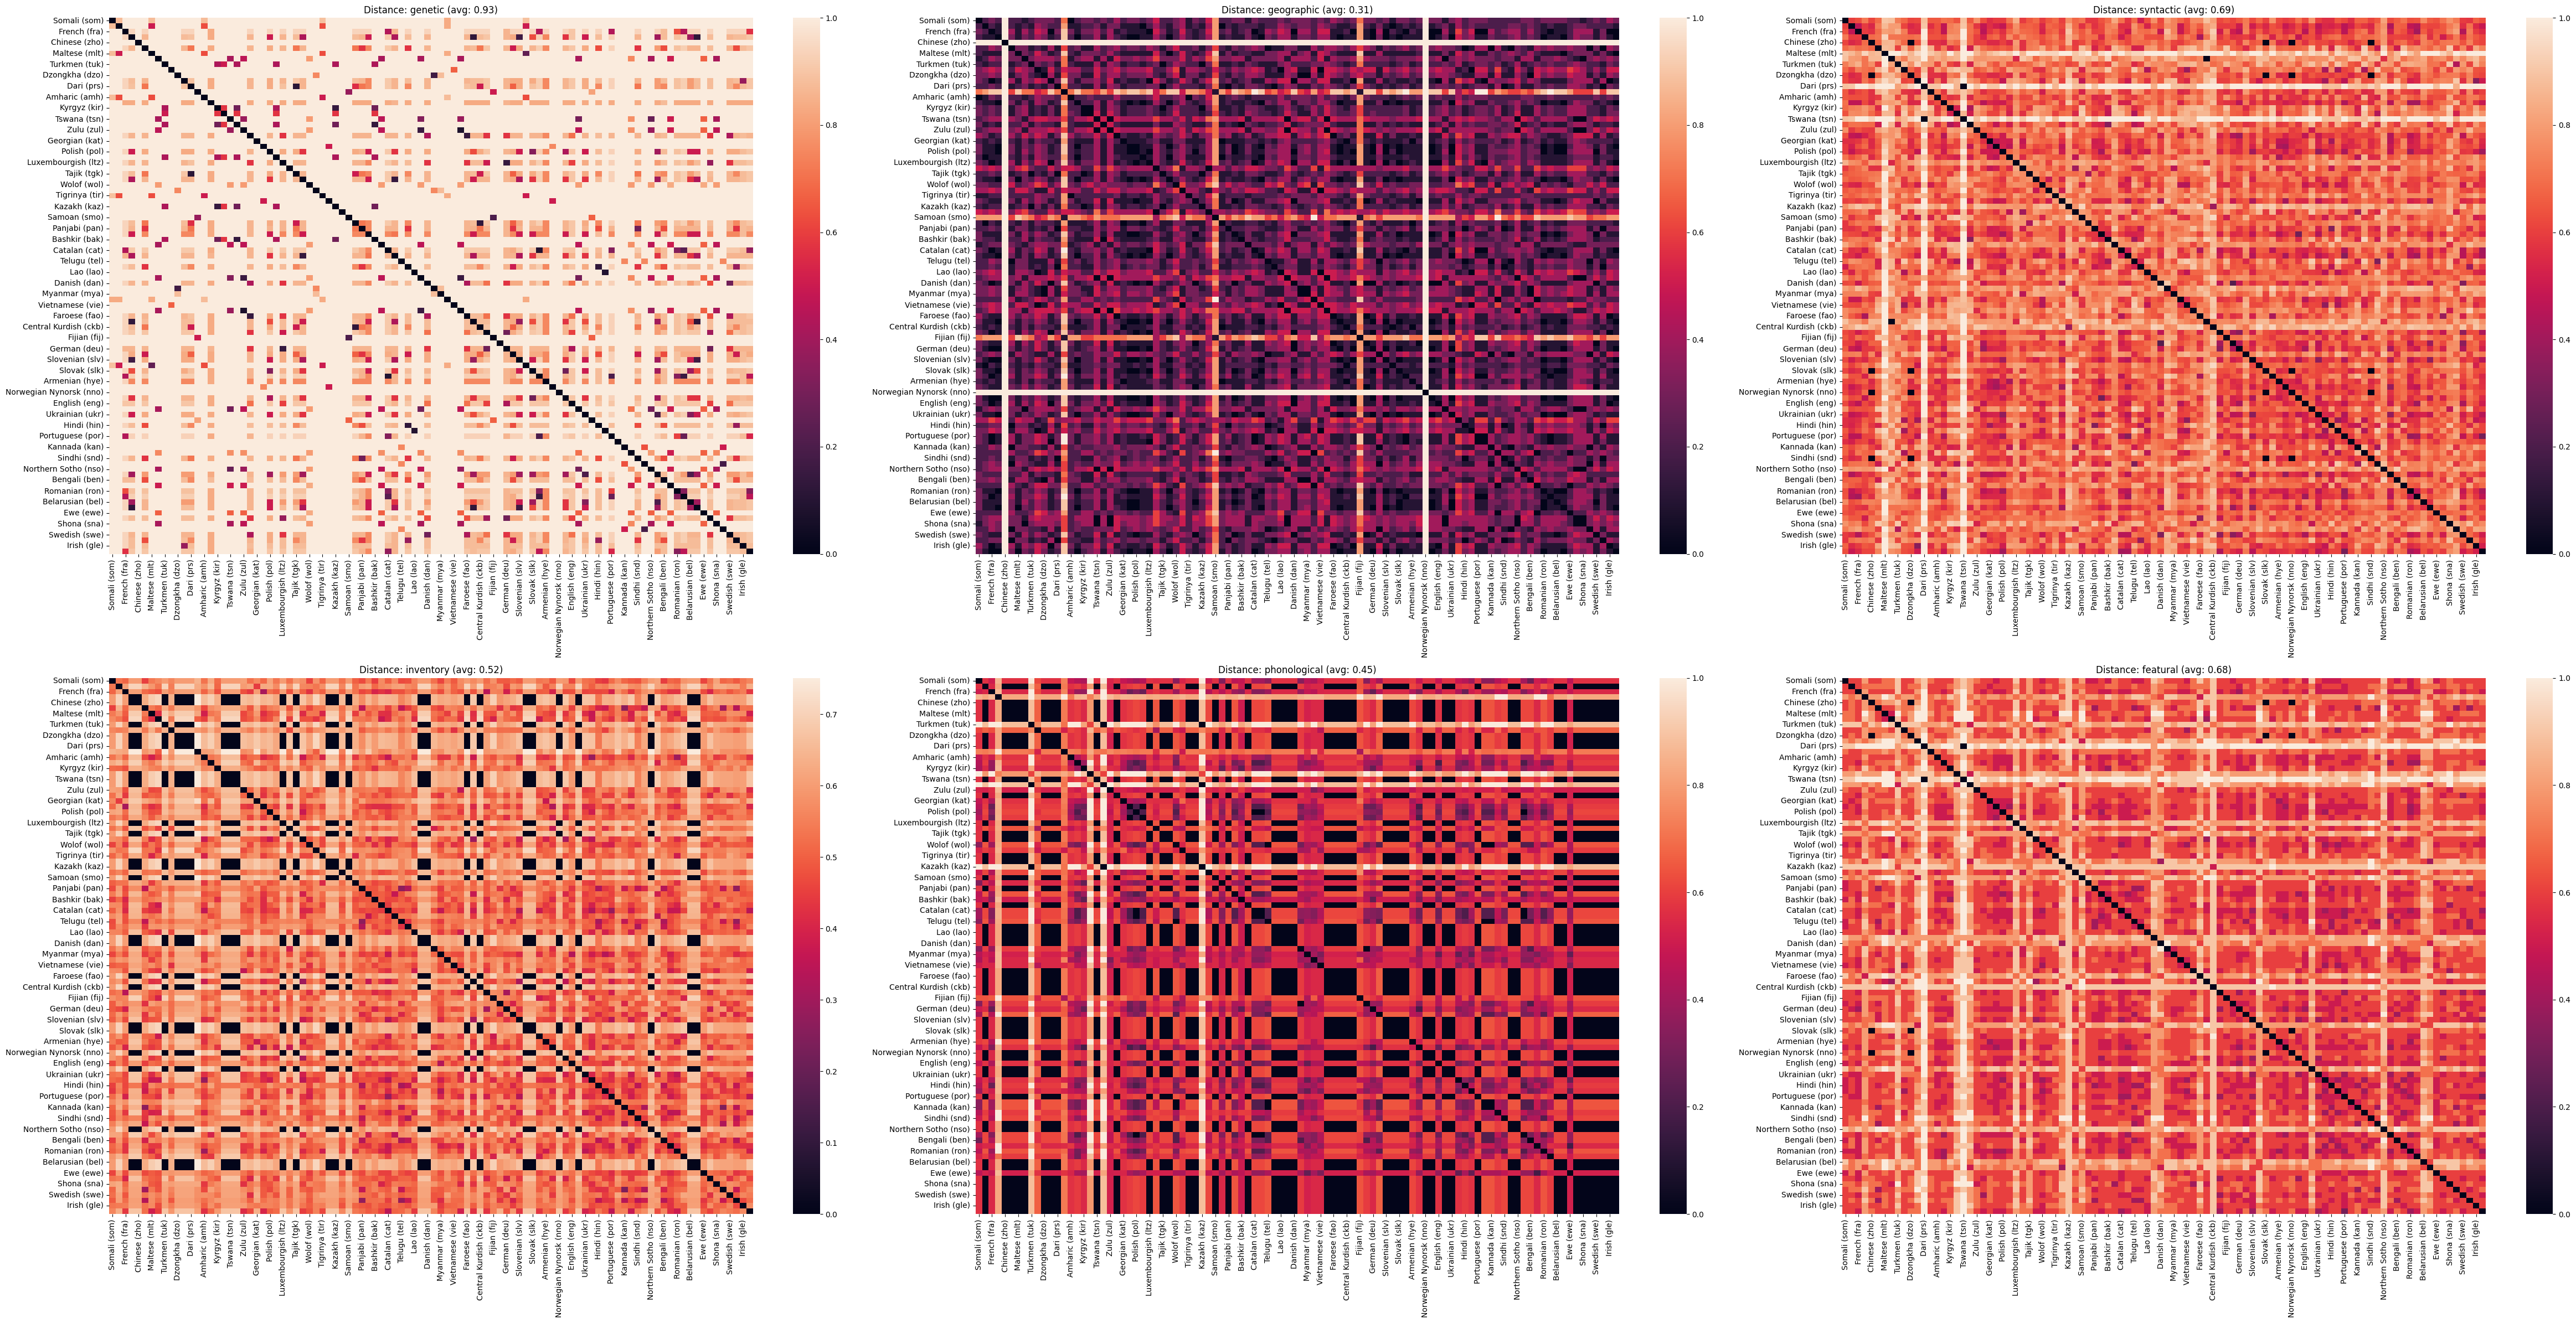

In [84]:
plot_heatmaps_all_distances(True)

In [85]:
def get_best_worst_langs(distance_matrix, language, N=5, make_human_readable=False):
    distances = distance_matrix[language]
    distances = distances.drop(index=language).sort_values()
    best, worst = distances.head(N), distances.tail(N)
    if make_human_readable:
        worst.index = [f"{lang_to_human_readable_language[l]} ({l})" for l in worst.index]
        best.index = [f"{lang_to_human_readable_language[l]} ({l})" for l in best.index]

    return {"chosen": f"{lang_to_human_readable_language[language]} ({language})" if make_human_readable else lang, "best": best.to_dict(), "worst": worst.to_dict()}

In [86]:
pprint(get_best_worst_langs(get_distance_matrix("phonological"), 'swe', make_human_readable=True, N=10))

{
│   'chosen': 'Swedish (swe)',
│   'best': {
│   │   'Danish (dan)': 0.0002,
│   │   'Samoan (smo)': 0.0002,
│   │   'Panjabi (pan)': 0.0002,
│   │   'Kinyarwanda (kin)': 0.0002,
│   │   'Urdu (urd)': 0.0002,
│   │   'Lao (lao)': 0.0002,
│   │   'Swati (ssw)': 0.0002,
│   │   'Irish (gle)': 0.0002,
│   │   'Xhosa (xho)': 0.0002,
│   │   'Faroese (fao)': 0.0002
│   },
│   'worst': {
│   │   'Basque (eus)': 0.641,
│   │   'Fijian (fij)': 0.641,
│   │   'Khmer (khm)': 0.6667,
│   │   'Sinhala (sin)': 0.6667,
│   │   'Maori (mri)': 0.7223,
│   │   'Uighur (uig)': 0.7877,
│   │   'Serbian (srp)': 0.8278,
│   │   'Tatar (tat)': 0.879,
│   │   'Kazakh (kaz)': 0.879,
│   │   'Turkmen (tuk)': 0.879
│   }
}

## Transfer learning experiments

### Tasks

#### Sentence tasks
- Language ID
- Orthography ID

#### Sentence pair tasks
- "Do these sentences have the same meaning?"
- "Do these sentences have the same orthography?"
- "Do these sentences have the same language?"

- XNLI (machine translated training data -> **bad**)

### Experimental conditions
- Which languages to pick to pretrain (up to K of L)
- Mix NTREX & FLORES vs not?
    - Sampling would need to happen at the *sentence ID* level
- Which model to use?

### What is the question we're trying to ask?

- For each evaluation language $l_{\text{eval}}$, how beneficial is it to have $l_{\text{finetune}}$ present in finetuning?
- How does this change given that some other languages are already present?
- Is is possible to "intelligently" pick transfer resources?
    - Formulated as maximizing some **expected utility**?

# Crucial prelim questions

1. How many languages are needed to get good performance on task?
2. How well do each of the tasks work?
3. How long does it take to train this?
4. Is SLURMification necessary?

In [87]:
cuda_report()

GPUs available? True
Number of GPUs: 2


### Multilingual BERT @ orthography classification task

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

In [89]:
def compute_metrics(eval_pred, id_to_label):
    
    f1 = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    metrics = {
        "macro_f1": f1.compute(
            predictions=predictions, references=labels, average="macro"
        )["f1"],
        "micro_f1": f1.compute(
            predictions=predictions, references=labels, average="micro"
        )["f1"],
    }

    # Per-class F1s
    class_f1s = f1.compute(
        predictions=predictions, references=labels, average=None
    )["f1"]
    
    class_ids = sorted(set(predictions) | set(labels))
    f1s_per_class = {
        id_to_label[class_id]: f1_score
        for class_id, f1_score in zip(class_ids, class_f1s)
    }
    metrics.update({f"f1_{id_to_label[class_id]}": f1_score
                    for class_id, f1_score in zip(class_ids, class_f1s)})

    # Confusion matrix
    labels_human_readable = [id_to_label[i] for i in labels]
    predictions_human_readable = [id_to_label[i] for i in predictions]

    _labels_set = set()
    for hum_readable in labels_human_readable, predictions_human_readable:
        _labels_set.update(hum_readable)

    _labels = sorted(_labels_set)

    remove_zero_rows = lambda df: df.loc[~(df==0).all(axis=1)]
    remove_zero_cols = lambda df: df.loc[:, (df != 0).any(axis=0)]

    cm = sk_confusion_matrix(
        y_true=labels_human_readable,
        y_pred=predictions_human_readable,
        labels=_labels,
    )
    confusion_df = pd.DataFrame(cm)
    confusion_df.columns = _labels
    confusion_df.index = _labels
#     confusion_df = remove_zero_rows(confusion_df)
#     confusion_df = remove_zero_cols(confusion_df)

    print("\n\n")
    pprint(confusion_df)
    print("\n\n")
    
    metrics['confusion_matrix'] = confusion_df

    return metrics

## Let's train our model!

#### Training arguments:

In [90]:
orth_clf_output_dir="./orth_clf_results"
batch_size=180
save_total_limit=1
learning_rate=5e-5
save_steps=-1
eval_steps=-1
warmup_steps=0
logging_steps=0
num_train_epochs=None
max_steps=20

In [91]:
def experiment(
    flores_path,
    ntrex_path,
    model_name,
    label_column,
    text_column,
    finetune_langs,
    test_langs,
    max_length_tokens,
    output_dir,
    batch_size,
    learning_rate,
    max_steps,
    compute_metrics,
    label_to_id=None,
    save_total_limit=1,
    save_steps=0,
    eval_steps=0,
    warmup_steps=0,
    logging_steps=0,
    num_train_epochs=None,
    data_loading_functions=None,
    
):
    if not data_loading_functions:
        data_loading_functions = [add_orthography_column, rename_to_label]
    
    _load_data_for_text_clf = ft.partial(
        load_data_for_text_clf,
        flores_path=flores_path,
        ntrex_path=ntrex_path,
        model_name=model_name,
        label_column=label_column,
        text_column=text_column,
        finetune_langs=finetune_langs,
        test_langs=test_langs,
        max_length_tokens=max_length_tokens
    )
    
    data_ft, data_test, flores, ntrex, language_to_id, id_to_language = \
    _load_data_for_text_clf(
        intermediate_functions=data_loading_functions
    )
    
    if not label_to_id:
        id_to_label = dict(enumerate(sorted(set(data_ft['label']) | set(data_test['label']))))
    
    label_to_id = invert_dict(id_to_label)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    clf_preprocess_function = ft.partial(
        single_sentence_preprocess_function, 
        label_to_id=label_to_id, 
        tokenizer=tokenizer, 
        max_length_tokens=max_length_tokens
    )

    data_ft = data_ft.map(clf_preprocess_function, batched=True)
    data_test = data_test.map(clf_preprocess_function, batched=True)
    
    label_set = set(data_ft['label']) | set(data_test['label'])

    # Load the XLM-R tokenizer and model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_set)
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=save_total_limit,
        learning_rate=learning_rate,
        save_steps=save_steps,
        eval_steps=eval_steps,
        evaluation_strategy="no"
        if eval_steps < 0
        else {0: "epoch"}.get(eval_steps, "steps"),
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        logging_strategy="no"
        if logging_steps < 0
        else {0: "epoch"}.get(logging_steps, "steps"),
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,

    )
    
    pprint(training_args)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    compute_metrics = ft.partial(
        compute_metrics,
        id_to_label=id_to_label
    )
    
    # Define the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_ft,
        eval_dataset=data_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        
    )
    metrics_before_train = trainer.evaluate()
    try:
        trainer.train(resume_from_checkpoint=True)
    except ValueError:
        trainer.train()
    metrics_after_train = trainer.evaluate()
    
    return trainer, metrics_before_train, metrics_after_train

In [92]:
MBERT = "bert-base-multilingual-cased"
text = "text"
orthography = 'orthography'

orth_clf_output_dir="./orth_clf_results"
batch_size=160
save_total_limit=4
learning_rate=5e-5
save_steps=400
eval_steps=-1
warmup_steps=0
logging_steps=0
num_train_epochs=1
max_steps=0

rename_orth_to_label = ft.partial(_rename_text_and_label_col,
                                  text_column=text, 
                                  label_column=orthography)

In [93]:
orth_clf_experiment = ft.partial(
    experiment,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MBERT,
    label_column=orthography,
    text_column=text,
    max_length_tokens=MAX_LENGTH_TOKENS,
    output_dir=orth_clf_output_dir,
    batch_size=batch_size,
    learning_rate=learning_rate,
    max_steps=max_steps,
    save_total_limit=1,
    save_steps=save_steps,
    eval_steps=eval_steps,
    warmup_steps=warmup_steps,
    logging_steps=logging_steps,
    num_train_epochs=num_train_epochs,
    data_loading_functions=[add_orthography_column, rename_orth_to_label],
    test_langs=None,
    compute_metrics=compute_metrics
)

In [94]:
# exp_results = orth_clf_experiment(finetune_langs="flores")

In [95]:
def plot_confusion_matrix(confusion_matrix, title, figsize=(15,15), should_normalize=False, normalize_this="rows"):
    
    if should_normalize:
        normalizer = confusion_matrix.sum(axis=({"rows": 0, "columns": 1}[normalize_this]))
        confusion_matrix = confusion_matrix / normalizer
        confusion_matrix = confusion_matrix.round(2).fillna(0)
    confusion_matrix_display = ConfusionMatrixDisplay(
        confusion_matrix.to_numpy(), 
        display_labels=confusion_matrix.columns
    )
    cm_fig, cm_ax = plt.subplots(figsize=figsize)
    cm_plot  =confusion_matrix_display.plot(ax=cm_ax)
    plt.tight_layout()
    plt.title(title)
    

In [96]:
# plot_confusion_matrix(exp_results[1]['eval_confusion_matrix'], should_normalize=True,
#                       title="Zero-shot orthography classification performance")

In [97]:
# plot_confusion_matrix(exp_results[-1]['eval_confusion_matrix'], should_normalize=True,
#                       title="Performance after single epoch")

In [98]:
%%bash
rm -vrf orth_clf_results/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [99]:
# exp_results_few = orth_clf_experiment(finetune_langs=["fin"])

In [100]:
# cm_few_before = exp_results_few[1]['eval_confusion_matrix']
# cm_few_after = exp_results_few[-1]['eval_confusion_matrix']

In [101]:
# plot_confusion_matrix(cm_few_before, should_normalize=True,
#                       title="Zero-shot performance")

What about training on just a few

In [102]:
# plot_confusion_matrix(cm_few_after, should_normalize=True,
#                       title="Performance after single epoch")

# Sentence pair classification

In [103]:
lang_pairs

['eng-fin']

In [104]:
def create_pairs_data(dataset, lang_pairs, n_pos, n_neg, num_rows):

    indices = [ix for ix in range(num_rows)]
    if n_pos > 0:
        positive_indices = np.random.randint(low=0, high=num_rows, size=n_pos)
    else:
        positive_indices = indices
        n_pos = len(indices)
    
    potential_negative_pairs = [
        (a, b) for a, b in it.combinations(indices, 2) if a != b
    ]
    
    if n_neg < 0:
        n_neg = n_pos
    
    if n_neg > 0:
        negative_indices = np.random.choice(
            range(len(potential_negative_pairs)), size=n_neg
        )
    else:
        negative_indices = list(range(len(potential_negative_pairs)))
        
        
    negative_indices = [potential_negative_pairs[idx] for idx in negative_indices]
    negative_as = [a for (a,b) in negative_indices]
    negative_bs = [b for (a,b) in negative_indices]
    
    N_lang_pairs = len(lang_pairs)
    positive_examples = []
    negative_examples = []
    for ix, pair in enumerate(lang_pairs, start=1):
        print(f"pair {ix}/{N_lang_pairs}: {pair}")
        lang1, lang2 = pair.split("-")

        lang1_pos = dataset[lang1][positive_indices]["text"]
        lang2_pos = dataset[lang2][positive_indices]["text"]
        lang1_neg = dataset[lang1][negative_as]["text"]
        lang2_neg = dataset[lang2][negative_bs]["text"]
        
        _positive_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": s1,
                "sentence2": s2,
                "label": "yes",
            }

            for s1, s2 in zip(lang1_pos, lang2_pos)
        ]
        positive_examples.extend(_positive_examples)

        
        _negative_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": s1,
                "sentence2": s2,
                "label": "no",
            }

            for s1, s2 in zip(lang1_neg, lang2_neg)
        ]
        negative_examples.extend(_negative_examples)

    sentence_pairs = ds.Dataset.from_pandas(
        pd.DataFrame.from_records(positive_examples + negative_examples)
    )

    return sentence_pairs

In [105]:
all_available_lang_pairs = [f"{a}-{b}" for a,b in it.product(language_to_id, language_to_id) if a != b]

In [106]:
len(all_available_lang_pairs)

9506

In [107]:
# _ = create_pairs_data(ntrex, all_available_lang_pairs, -1, -1, num_rows=ntrex["eng"].num_rows)

In [108]:
def load_data_for_sentence_pair_clf(
    flores_path,
    ntrex_path,
    lang_pairs,
    n_pos, n_neg,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )

    # STEP 2: CREATE PAIRS
    data_for_finetune = create_pairs_data(ntrex, lang_pairs, n_pos, n_neg, num_rows=ntrex["eng"].num_rows)
    data_for_test = create_pairs_data(flores, lang_pairs, n_pos, n_neg, num_rows=flores["eng"].num_rows)
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

_load_data_for_sentence_pair_clf = ft.partial(
    load_data_for_sentence_pair_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
)

In [109]:
def sentence_pair_experiment(
    flores_path,
    ntrex_path,
    model_name,
    lang_pairs,
    max_length_tokens,
    output_dir,
    batch_size,
    learning_rate,
    max_steps,
    compute_metrics,
    n_pos=-1, n_neg=-1,
    label_to_id=None,
    save_total_limit=1,
    save_steps=0,
    eval_steps=0,
    warmup_steps=0,
    logging_steps=0,
    num_train_epochs=None,
    data_loading_functions=None,
    verbose=False
    
):
    if not data_loading_functions:
        data_loading_functions = []
    
    _load_data_for_sentence_pair_clf = ft.partial(
        load_data_for_sentence_pair_clf,
        flores_path=flores_path,
        ntrex_path=ntrex_path,
        lang_pairs=lang_pairs,
        n_pos=n_pos, n_neg=n_neg
    )
    
    data_ft, data_test, flores, ntrex, language_to_id, id_to_language = \
    _load_data_for_sentence_pair_clf(
        intermediate_functions=data_loading_functions
    )
    
    if not label_to_id:
        id_to_label = dict(enumerate(sorted(set(data_ft['label']) | set(data_test['label']))))
    
    label_to_id = invert_dict(id_to_label)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    clf_preprocess_function = ft.partial(
        sentence_pair_preprocess_function, 
        label_to_id=label_to_id, 
        tokenizer=tokenizer, 
        max_length_tokens=max_length_tokens
    )

    data_ft = data_ft.map(clf_preprocess_function, batched=True)
    data_test = data_test.map(clf_preprocess_function, batched=True)
    
    label_set = set(data_ft['label']) | set(data_test['label'])

    # Load the tokenizer and model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_set)
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=save_total_limit,
        learning_rate=learning_rate,
        save_steps=save_steps,
        eval_steps=eval_steps,
        evaluation_strategy="no"
        if eval_steps < 0
        else {0: "epoch"}.get(eval_steps, "steps"),
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        logging_strategy="no"
        if logging_steps < 0
        else {0: "epoch"}.get(logging_steps, "steps"),
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,
        disable_tqdm=False,
        log_level="error",
        log_level_replica="error",
    )
    
    if verbose:
        pprint(training_args)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    compute_metrics = ft.partial(
        compute_metrics,
        id_to_label=id_to_label
    )
    
    # Define the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_ft,
        eval_dataset=data_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        
    )
    metrics_before_train = trainer.evaluate()
    try:
        trainer.train(resume_from_checkpoint=True)
    except ValueError:
        trainer.train()
    metrics_after_train = trainer.evaluate()
    
    return metrics_before_train, metrics_after_train

In [110]:
same_sentence_output_dir = "./same_sentence_results"

In [111]:
def compute_same_sentence_metrics(eval_pred, id_to_label, verbose=True):
    
    f1 = evaluate.load("f1")
    predictions, labels = eval_pred
    
    if verbose:
        print("predictions")
        print(predictions)
    
    predictions = np.argmax(predictions, axis=1)

    metrics = {
        "macro_f1": f1.compute(
            predictions=predictions, references=labels, average="macro"
        )["f1"],
        "micro_f1": f1.compute(
            predictions=predictions, references=labels, average="micro"
        )["f1"],
    }

    # Per-class F1s
    class_f1s = f1.compute(
        predictions=predictions, references=labels, average=None
    )["f1"]
    
    class_ids = sorted(set(predictions) | set(labels))
    f1s_per_class = {
        id_to_label[class_id]: f1_score
        for class_id, f1_score in zip(class_ids, class_f1s)
    }
    metrics.update({f"f1_{id_to_label[class_id]}": f1_score
                    for class_id, f1_score in zip(class_ids, class_f1s)})

    # Confusion matrix
    labels_human_readable = [id_to_label[i] for i in labels]
    predictions_human_readable = [id_to_label[i] for i in predictions]

    _labels_set = set()
    for hum_readable in labels_human_readable, predictions_human_readable:
        _labels_set.update(hum_readable)

    _labels = sorted(_labels_set)

    remove_zero_rows = lambda df: df.loc[~(df==0).all(axis=1)]
    remove_zero_cols = lambda df: df.loc[:, (df != 0).any(axis=0)]

    cm = sk_confusion_matrix(
        y_true=labels_human_readable,
        y_pred=predictions_human_readable,
        labels=_labels,
    )
    confusion_df = pd.DataFrame(cm)
    confusion_df.columns = _labels
    confusion_df.index = _labels

    if verbose:
        print("\n\n")
        pprint(confusion_df)
        print("\n\n")
    
    metrics['confusion_matrix'] = confusion_df

    return metrics

In [112]:
same_sentence_experiment = ft.partial(
    sentence_pair_experiment,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MBERT,
    max_length_tokens=MAX_LENGTH_TOKENS,
    output_dir=same_sentence_output_dir,
    batch_size=batch_size,
    learning_rate=learning_rate,
    max_steps=max_steps,
    save_total_limit=1,
    save_steps=save_steps,
    eval_steps=eval_steps,
    warmup_steps=warmup_steps,
    logging_steps=logging_steps,
    num_train_epochs=1,
    data_loading_functions=None,
    compute_metrics=ft.partial(compute_same_sentence_metrics, verbose=False),
    verbose=False
)

### FInnish sentence pair classification

- Let's do an experiment on `fin-*` sentence pair classification.
- Each pair will be trained and evaluated as a separate experiment.
- At the end we can inspect whether there are any patterns

In [116]:
# with open("../data/all_lang_pairs.txt", 'w') as f_out:
#     print("\n".join(all_available_lang_pairs), file=f_out)

In [117]:
all_fin_pairs = sorted([p for p in all_available_lang_pairs if p.startswith("fin-")])

In [93]:
len(all_fin_pairs)

97

In [ ]:
all_fin_same_sentence_exp_results = {}
for pair in track(all_fin_pairs, description="Classifying pairs..."):
    all_fin_same_sentence_exp_results[pair] = same_sentence_experiment(lang_pairs=[pair])

Output()

pair 1/1: fin-afr

pair 1/1: fin-afr

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.346200


pair 1/1: fin-amh

pair 1/1: fin-amh

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.633000


pair 1/1: fin-arb

pair 1/1: fin-arb

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.356800


pair 1/1: fin-bak

pair 1/1: fin-bak

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.363400


pair 1/1: fin-bel

pair 1/1: fin-bel

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.341600


pair 1/1: fin-bem

pair 1/1: fin-bem

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.458000


pair 1/1: fin-ben

pair 1/1: fin-ben

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.369500


pair 1/1: fin-bod

pair 1/1: fin-bod

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.633100


pair 1/1: fin-bos

pair 1/1: fin-bos

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.334300


pair 1/1: fin-bul

pair 1/1: fin-bul

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.330700


pair 1/1: fin-cat

pair 1/1: fin-cat

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

In [ ]:
fin_same_sent_results_before = {pair: a for pair, (a,b) in all_fin_same_sentence_exp_results.items()}

In [ ]:
fin_same_sent_results_after = {pair: b for pair, (a,b) in all_fin_same_sentence_exp_results.items()}

In [ ]:
false_positives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['no', 'yes'] 
    for pair in fin_same_sent_results_before
]

false_negatives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['yes', 'no'] 
    for pair in fin_same_sent_results_before
]

true_positives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['yes', 'yes'] 
    for pair in fin_same_sent_results_before
]

true_negatives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['no', 'no'] 
    for pair in fin_same_sent_results_before
]

In [ ]:
false_positives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['no', 'yes'] 
    for pair in fin_same_sent_results_after
]

false_negatives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['yes', 'no'] 
    for pair in fin_same_sent_results_after
]

true_positives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['yes', 'yes'] 
    for pair in fin_same_sent_results_after
]

true_negatives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['no', 'no'] 
    for pair in fin_same_sent_results_after
]

In [ ]:
metric_df_after = pd.DataFrame({
    "language_pair": [pair for pair in fin_same_sent_results_after],
    "false_positives": false_positives_after,
    "false_negatives": false_negatives_after,
    'true_positives': true_positives_after,
    'true_negatives': true_negatives_after
})

metric_df_after['total_correct'] = metric_df_after.true_positives + metric_df_after.true_negatives
metric_df_after['total_incorrect'] = metric_df_after.false_positives + metric_df_after.false_negatives

In [ ]:
metric_df_before = pd.DataFrame({
    "language_pair": [pair for pair in fin_same_sent_results_before],
    "false_positives": false_positives_before,
    "false_negatives": false_negatives_before,
    'true_positives': true_positives_before,
    'true_negatives': true_negatives_before
})

metric_df_before['total_correct'] = metric_df_before.true_positives + metric_df_before.true_negatives
metric_df_before['total_incorrect'] = metric_df_before.false_positives + metric_df_before.false_negatives

In [ ]:
pairs_hum = []
for pair in metric_df_before.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)

In [ ]:
metric_df_before['language_pair_hum'] = pairs_hum

In [ ]:
pairs_hum = []
for pair in metric_df_after.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)

In [ ]:
metric_df_after['language_pair_hum'] = pairs_hum

In [ ]:
metric_df_before_after = pd.merge(
    left=metric_df_before[['language_pair', 'total_incorrect']],
    right=metric_df_after[['language_pair', 'total_incorrect']],
    left_on="language_pair", right_on="language_pair",
    suffixes=["_before", "_after"]
)

In [ ]:
metric_df_before_after.sort_values('total_incorrect_before', ascending=False)

In [ ]:
g = sns.scatterplot(
    data=metric_df_before_after, 
    x='total_incorrect_before', 
    y='total_incorrect_after'
)


g.set_xlim(0, 2000)
g.set_ylim(0, 2000)
g.axline([0,0], [1,1], ls='--', c='k', alpha=0.5)
g.set_title("Same sentence detection performance")

In [ ]:
def incorrect(df):
    arr = np.array(df)
    total = np.sum(arr, axis=None)
    trace = np.trace(arr)
    return total - trace

In [ ]:
incorrect(fin_same_sent_results_before['fin-est']['eval_confusion_matrix'])

In [ ]:
metric_df_before_after['ratio'] = (metric_df_before_after.total_incorrect_after 
 / metric_df_before_after.total_incorrect_before)

In [ ]:
pairs_hum = []
for pair in metric_df_before_after.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)
    
metric_df_before_after['language_pair_hum'] = pairs_hum

In [ ]:
metric_df_before_after.set_index('language_pair_hum')['ratio'].sort_values().plot.barh(figsize=(6, 18))

In [ ]:
# class FrozenHuggingFaceModel:
    
#     def __init__(self, model, tokenizer):
#         self.model = model
#         self.tokenizer = tokenizer
#         for param in self.model.parameters():
#             param.requires_grad = False

#     def __call__(self, text):
#         input_ids = torch.tensor(
#             self.tokenizer.encode(text, add_special_tokens=True)
#         ).unsqueeze(0)
#         tokens = [self.tokenizer.convert_ids_to_tokens(ix) for ix in input_ids][0]
#         out = self.model(input_ids, output_hidden_states=True)
#         last_hidden = out.hidden_states[-1]
#         return  input_ids, tokens, last_hidden.squeeze(), out

In [ ]:
# mbert_tokenizer = AutoTokenizer.from_pretrained(MBERT)
# mbert_model = AutoModelForSequenceClassification.from_pretrained(MBERT)

In [ ]:
# frozen_mbert = FrozenHuggingFaceModel(mbert_model, mbert_tokenizer)

In [ ]:
# natalie_input_ids, natalie_tokens, natalie_feats, natalie_out = frozen_mbert("hello this is natalie")

In [ ]:
# np.random.seed(12345)
# a = np.random.choice(['yes', 'no'], size=5)
# np.random.seed(12345)
# b = np.random.choice(['yes', 'no'], size=5)

# a == b